In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime, timedelta
import pandas_datareader.data as web
from calendar import monthrange

In [2]:
# sem mensagem de erro
pd.options.mode.chained_assignment = None

In [3]:
# mostra o dataframe inteiro
pd.set_option('display.max_rows', None)

## Base de Dados

### IBOVESPA, VALE e BANCO DO BRASIL.

Para este trabalho, a base de dados utilizada será composta pelo índice do BOVESPA, e as ações preferenciais da VALE e do BANCO DO BRASIL. Como parte do exercício será transformar as séries de valores nominais para valores reais, usaremos todos dias do ano como índice, não só os dias úteis. Quando a série do ipca estiver sendo trabalhada vai ficar mais claro o motivo dessa abordagem.

In [4]:
# criando um dataframe com as datas diárias de 01/01/2000 até hoje
date_today = datetime.now().date()
days = pd.date_range(start = '2000-01-01', end = date_today, freq='D')

Os dados coletados foram as séries como já dito anteriormente, do índice do BOVESPA, e as ações preferenciais da VALE e do BANCO DO BRASIL. Os dados começam do dia 01/01/2000 até o dia atual que é feito esse trabalho, 12/09/2022.

In [5]:
ibov = web.get_data_yahoo('^BVSP', start = "2000-01-01")
vale3 = web.get_data_yahoo('VALE3.SA', start = "2000-01-01")
bbas3 = web.get_data_yahoo('BBAS3.SA', start = "2000-01-01")

Os preços trabalhos aqui devem ser os ajustados por dividendos e pagamentos. Por isso, a partir daqui o dataframe carregará somente a coluna 'Adj Close', renomeada para a sigla da série temporal.

In [6]:
ibov = pd.DataFrame(data = ibov['Adj Close'], index = days)
ibov = ibov.rename(columns={'Adj Close': 'IBOV'})

vale3 = pd.DataFrame(data = vale3['Adj Close'], index = days)
vale3 = vale3.rename(columns={'Adj Close': 'VALE3'})

bbas3 = pd.DataFrame(data = bbas3['Adj Close'], index = days)
bbas3 = bbas3.rename(columns={'Adj Close': 'BBAS3'})

Aqui estamos criando uma função que normaliza os dados com valores NaN (Not a Number). A abordagem é simples, se uma entrada tem valor NaN, essa entrada deve receber o valor de uma linha anterior (os sábados receberão os preços de sexta-feira).

In [7]:
def normalize_nan(df):
    for i in range(len(df)):
        if i == 0:
            pass
        elif math.isnan(df.iloc[i]) == True:
            df.iloc[i] = df.iloc[i-1]
        else:
            continue

Normalizamos as três séries.

In [8]:
normalize_nan(ibov)
normalize_nan(vale3)
normalize_nan(bbas3)

Veremos as 10 primeiras linhas de cada um dos três dataframes.

In [9]:
ibov.head(10)

,IBOV
2000-01-01,NaN
2000-01-02,NaN
2000-01-03,16930.0
2000-01-04,15851.0
2000-01-05,16245.0
2000-01-06,16107.0
2000-01-07,16309.0
2000-01-08,16309.0
2000-01-09,16309.0
2000-01-10,17022.0


In [10]:
vale3.head(10)

,VALE3
2000-01-01,NaN
2000-01-02,NaN
2000-01-03,1.707494
2000-01-04,1.666840
2000-01-05,1.666840
2000-01-06,1.666840
2000-01-07,1.727822
2000-01-08,1.727822
2000-01-09,1.727822
2000-01-10,1.870113


In [11]:
bbas3.head(10)

,BBAS3
2000-01-01,NaN
2000-01-02,NaN
2000-01-03,1.176301
2000-01-04,1.120355
2000-01-05,1.131831
2000-01-06,1.147610
2000-01-07,1.121789
2000-01-08,1.121789
2000-01-09,1.121789
2000-01-10,1.183474


Mais uma função a ser criada. Essa recebe com input um código referente a uma série temporal contida na base de dados do Banco Central do Brasil. Essa função nos entregará a série mensal do IPCA.

### IPCA

In [12]:
def consulta_bc(codigo_bcb):
  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
  df = pd.read_json(url)
  df['data'] = pd.to_datetime(df['data'], dayfirst=True)
  df.set_index('data', inplace=True)
  return df

Função criada. O valor de entrada 433 é referente a série mensal do IPCA. Esses valores são os valores de variação mês a mês do Índice de Preços ao Consumidor Amplo.

In [13]:
ipca = pd.DataFrame(consulta_bc(433), index = days)

Como teremos que deixar séries temporais diárias em valores reais, precisamos criar um índice de preços com a evolução diária dos preços. Para isso, o dataframe de IPCA é criado para todos os dias do ano (não só os úteis). A abordagem aqui será de homogeneizar diariamente a variação mensal dos preços. Primeiro normalizamos as entradas NaN.

In [14]:
normalize_nan(ipca['valor'])

A variação está em porcentagem. A interpretação desse valor é que os preços de determinado mês aumentaram/diminuiram $x$% em relação aos preços do mês passado. Dessa forma, é necessário escrever como

$$
    1 + IPCA_{mensal} = 1 + \frac{x}{100}
$$

onde $x$ é o valor de variação mensal dos preços em porcentagem, em relação aos preços do mês passado.

In [15]:
ipca['1 + IPCA_m'] = 1 + (ipca['valor']/100)

Como precisamos deixar essa taxa diária, é necessário criar outra coluna, a princípio com valores NaN.

In [16]:
ipca['1 + IPCA_d'] = np.nan

A transição dessa taxa de mensal para diário é a seguinte conta:

$$
    (1 + IPCA_{diário}) = (1 + IPCA_{mensal})^{\frac{1}{d}}
$$

onde $d$ é a quantidade de dias que tem determinado mês. 

Como cada mês tem determinada quantidade específica de dias, é necessário fazer um loop para capturar corretamente como foi a evolução dos preços de cada dia, caso contrário poderíamos obter após mais de 20 anos dados distorções na evolução agregada dos preços.

In [17]:
for i in range(len(ipca)):
    month = pd.DatetimeIndex(ipca.index).month[i]
    year = pd.DatetimeIndex(ipca.index).year[i]
    days_of_the_month = monthrange(year, month)[1]
    ipca['1 + IPCA_d'][i] = (ipca['1 + IPCA_m'][i])**(1/days_of_the_month)

Finalmente vamos criar o índice de preços. Novamente é criada uma coluna com valores NaN.

In [18]:
ipca['IPCA_index'] = np.nan

Para criar o índice, é normalizado para o primeiro dia da amostra o valor 1, esse é o dia que serve como base. O índice é obtido através de

$$
    ÍndiceIPCA_{d} = (1 + IPCA_{diário})^{d}
$$

onde $d$ agora, é a quantidade de dias à frente da data base (01/01/2000). A interpretação desse valor é que os preços evoluíramos $(ÍndiceIPCA_{d} - 1)\cdot 100$% em $d$ dias a partir do dia 01/01/2000.

In [19]:
for i in range(len(ipca)):
    if i == 0:
        ipca['IPCA_index'][i] = 1
    else:
        ipca['IPCA_index'][i] = (ipca['IPCA_index'][i-1]*ipca['1 + IPCA_d'][i])

In [21]:
ipca.head(10)

,valor,1 + IPCA_m,1 + IPCA_d,IPCA_index
2000-01-01,0.62,1.0062,1.000199,1.000000
2000-01-02,0.62,1.0062,1.000199,1.000199
2000-01-03,0.62,1.0062,1.000199,1.000399
2000-01-04,0.62,1.0062,1.000199,1.000598
2000-01-05,0.62,1.0062,1.000199,1.000798
2000-01-06,0.62,1.0062,1.000199,1.000997
2000-01-07,0.62,1.0062,1.000199,1.001197
2000-01-08,0.62,1.0062,1.000199,1.001397
2000-01-09,0.62,1.0062,1.000199,1.001596
2000-01-10,0.62,1.0062,1.000199,1.001796


## Base de dados pronta

### IBOVESPA, VALE e BANCO DO BRASIL nominais e reais.

Após deixar o índice do IPCA pronto, unimos os dataframes.

In [22]:
ibov_ = pd.merge(ibov, ipca['IPCA_index'], how='left', left_index=True, right_index=True)

vale3_ = pd.merge(vale3, ipca['IPCA_index'], how='left', left_index=True, right_index=True)

bbas3_ = pd.merge(bbas3, ipca['IPCA_index'], how='left', left_index=True, right_index=True)

As séries reais nada mais são do que as séries nominais divididas pelo índice. Isso é, para o Ibovespa por exemplo

$$
    IbovespaREAL_{d} = \frac{IbovespaNOMINAL_{d}}{ÍndiceIPCA_{d}}
$$

In [23]:
ibov_['IBOV_real'] = ibov_['IBOV']/ibov_['IPCA_index']

vale3_['VALE3_real'] = vale3_['VALE3']/vale3_['IPCA_index']

bbas3_['BBAS3_real'] = bbas3_['BBAS3']/bbas3_['IPCA_index']

### RETORNOS

Obtido as séries reais, agora podemos transformar em taxas de retorno diárias:

$$
    r_{t}^{i} = \frac{P_{t}^{i} - P_{t-1}^{i}}{P_{t-1}^{i}}
$$

onde o subscrito $t$ representa o período, o superescrito $i$ representa o índice/ação, $P$ representa o preço e $r$ a taxa de retorno.

In [25]:
# Nominal
ibov_['IBOV_(t)'] = ((ibov_['IBOV'] - ibov_['IBOV'].shift(1))/ibov_['IBOV'].shift(1))

vale3_['VALE3_(t)'] = ((vale3_['VALE3'] - vale3_['VALE3'].shift(1))/vale3_['VALE3'].shift(1))

bbas3_['BBAS3_(t)'] = ((bbas3_['BBAS3'] - bbas3_['BBAS3'].shift(1))/bbas3_['BBAS3'].shift(1))

# Real
ibov_['IBOV_real_(t)'] = ((ibov_['IBOV_real'] - ibov_['IBOV_real'].shift(1))/ibov_['IBOV_real'].shift(1))

vale3_['VALE3_real_(t)'] = ((vale3_['VALE3_real'] - vale3_['VALE3_real'].shift(1))/vale3_['VALE3_real'].shift(1))

bbas3_['BBAS3_real_(t)'] = ((bbas3_['BBAS3_real'] - bbas3_['BBAS3_real'].shift(1))/bbas3_['BBAS3_real'].shift(1))

Como adicionamos os preços aos dias em que o mercado não foi aberto, e esses preços teoricamente não evoluem nesses dias, teremos retornos nulos nesses casos. O estudo é uma análise de correlação entre séries, então se mantivermos isso em nossa base de dados, podemos acabar capturando uma correlação espúria. Portanto devemos retirar tais dados da nossa amostra.

In [26]:
delete_row = ibov_[ibov_['IBOV_(t)']==0].index
ibov_ = ibov_.drop(delete_row)

In [27]:
delete_row = vale3_[vale3_['VALE3_(t)']==0].index
vale3_ = vale3_.drop(delete_row)

In [28]:
delete_row = bbas3_[bbas3_['BBAS3_(t)']==0].index
bbas3_ = bbas3_.drop(delete_row)

In [29]:
ibov_.head(10)

,IBOV,IPCA_index,IBOV_real,IBOV_(t),IBOV_real_(t)
2000-01-01,NaN,1.000000,NaN,NaN,NaN
2000-01-02,NaN,1.000199,NaN,NaN,NaN
2000-01-03,16930.0,1.000399,16923.250253,NaN,NaN
2000-01-04,15851.0,1.000598,15841.521597,-0.063733,-0.063920
2000-01-05,16245.0,1.000798,16232.049287,0.024856,0.024652
2000-01-06,16107.0,1.000997,16090.950727,-0.008495,-0.008693
2000-01-07,16309.0,1.001197,16289.501285,0.012541,0.012339
2000-01-10,17022.0,1.001796,16991.482381,0.043718,0.043510
2000-01-11,16573.0,1.001996,16539.989250,-0.026378,-0.026572
2000-01-12,16617.0,1.002196,16580.595398,0.002655,0.002455


In [31]:
vale3_.head(10)

,VALE3,IPCA_index,VALE3_real,VALE3_(t),VALE3_real_(t)
2000-01-01,NaN,1.000000,NaN,NaN,NaN
2000-01-02,NaN,1.000199,NaN,NaN,NaN
2000-01-03,1.707494,1.000399,1.706813,NaN,NaN
2000-01-04,1.666840,1.000598,1.665843,-0.023809,-0.024004
2000-01-07,1.727822,1.001197,1.725756,0.036585,0.036379
2000-01-10,1.870113,1.001796,1.866760,0.082353,0.082137
2000-01-11,1.874178,1.001996,1.870445,0.002174,0.001974
2000-01-12,1.892473,1.002196,1.888326,0.009761,0.009560
2000-01-13,1.955487,1.002395,1.950814,0.033298,0.033092
2000-01-14,1.992077,1.002595,1.986920,0.018711,0.018508


In [32]:
bbas3_.head(10)

,BBAS3,IPCA_index,BBAS3_real,BBAS3_(t),BBAS3_real_(t)
2000-01-01,NaN,1.000000,NaN,NaN,NaN
2000-01-02,NaN,1.000199,NaN,NaN,NaN
2000-01-03,1.176301,1.000399,1.175832,NaN,NaN
2000-01-04,1.120355,1.000598,1.119685,-0.047561,-0.047751
2000-01-05,1.131831,1.000798,1.130929,0.010243,0.010042
2000-01-06,1.147610,1.000997,1.146467,0.013941,0.013739
2000-01-07,1.121789,1.001197,1.120448,-0.022500,-0.022695
2000-01-10,1.183474,1.001796,1.181352,0.054988,0.054777
2000-01-11,1.167693,1.001996,1.165368,-0.013334,-0.013531
2000-01-12,1.183474,1.002196,1.180881,0.013514,0.013312


## Teste de Box-Pierce

In [33]:
import statsmodels.api as sm
sm.stats.acorr_ljungbox(ibov_['IBOV_(t)'].dropna(), lags=[5,22,126,252,504], boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
5,12.309840,0.030780,12.300000,0.030900
22,51.746035,0.000339,51.625782,0.000352
126,185.078353,0.000481,183.121165,0.000675
252,307.170332,0.009976,300.922045,0.018695
504,544.573586,0.102749,522.146349,0.279013


O teste de Box Pierce contém como hipótese nula que os dados, nesse caso os retornos diários do Ibovespa, são independentemente distribuídos não contendo autocorrelação, enquanto a hipótese alternativa representa que os dados contém autocorrelação com cada defasagem (os lags do código).

Verificamos nos resultados que a correlação dos retornos do Ibovespa diário com a defasagem de uma semana representa um p-value de 0.03, isto é, em um teste com significância de 5%, rejeitaríamos a hipótese nula do teste, indicando que a série temporal contém autocorrelação com uma semana de defasagem. Enquanto que se a significância fosse de 1%, a hipótese nula não seria rejeitada indicando séries independentemente distribuídas. Esse caso é o mesmo quando trabalhamos com a defasagem de um ano (lag = 252) apresentando um p-value de 0.02 aproximadamente. Para as defasagens de um mês (lag = 22) e de um semestre (lag = 126) os p-values obtidos foram ambos abaixo de 0.01. Isso significa que em até um teste com 1% de significância a hipótese nula de distribuição independente seria rejeitada, nesse caso haveria autocorrelação. O último caso, é quando a série é defasada em dois anos  (lag = 504). Com um p-value de 0.28, qualquer teste com valores usuais de significância não seria rejeitado, indicando independência na distribuição dos dados.

In [34]:
sm.stats.acorr_ljungbox(ibov_['IBOV_real_(t)'].dropna(), lags=[5,22,126,252,504], boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
5,12.197322,0.032182,12.187566,0.032306
22,51.690587,0.000345,51.570219,0.000358
126,184.635374,0.000520,182.682411,0.000728
252,306.514204,0.010679,300.280228,0.019889
504,544.020897,0.105740,521.605433,0.284634


Para a série dos retornos diários do Ibovespa Real os resultados não foram muito distintos em comparação à série em valores nominais. De forma mais sucinta:

* Defasagem semanal: p-value = 0.03 > 0.01 = $\alpha$. Não rejeita-se a hipótese nula de distribuição independente.
* Defasagem mensal: p-value = 0.0003 < 0.01 = $\alpha$. Rejeita-se a hipótese nula de distribuição independente, indicando autocorrelação.
* Defasagem semestral: p-value = 0.0007 < 0.01 = $\alpha$. Rejeita-se a hipótese nula de distribuição independente, indicando autocorrelação.
* Defasagem anual: p-value = 0.02 > 0.01 = $\alpha$. Não rejeita-se a hipótese nula de distribuição independente.
* Defasagem de dois anos: p-value = 0.28 > 0.01 = $\alpha$. Não rejeita-se a hipótese nula de distribuição independente.

In [35]:
sm.stats.acorr_ljungbox(vale3_['VALE3_(t)'].dropna(), lags=[5,22,126,252,504], boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
5,28.424672,0.000030,28.400658,0.000030
22,63.594667,0.000006,63.475494,0.000007
126,187.989504,0.000288,186.225450,0.000394
252,328.955164,0.000791,322.108545,0.001855
504,570.513351,0.021173,547.410703,0.088385


Para a série dos retornos diários das ações preferenciais da Vale em valores nominais, temos:

* Defasagem semanal: p-value = 0.00003 < 0.01 = $\alpha$. Rejeita-se a hipótese nula de distribuição independente, indicando autocorrelação.
* Defasagem mensal: p-value = 0.000007 < 0.01 = $\alpha$. Rejeita-se a hipótese nula de distribuição independente, indicando autocorrelação.
* Defasagem semestral: p-value = 0.0007 < 0.01 = $\alpha$. Rejeita-se a hipótese nula de distribuição independente, indicando autocorrelação.
* Defasagem anual: p-value = 0.0018 < 0.01 = $\alpha$. Rejeita-se a hipótese nula de distribuição independente, indicando autocorrelação.
* Defasagem de dois anos: p-value = 0.088 > 0.01 = $\alpha$. Não rejeita-se a hipótese nula de distribuição independente.

In [36]:
sm.stats.acorr_ljungbox(vale3_['VALE3_real_(t)'].dropna(), lags=[5,22,126,252,504], boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
5,28.247046,0.000033,28.223197,0.000033
22,63.383576,0.000007,63.264707,0.000007
126,187.754949,0.000300,185.992135,0.000410
252,328.772717,0.000809,321.925872,0.001896
504,570.462824,0.021248,547.350519,0.088673


Para a série dos retornos diários das ações preferenciais da Vale em valores reais, temos:

* Defasagem semanal: p-value = 0.00003 < 0.01 = $\alpha$. Rejeita-se a hipótese nula de distribuição independente, indicando autocorrelação.
* Defasagem mensal: p-value = 0.000007 < 0.01 = $\alpha$. Rejeita-se a hipótese nula de distribuição independente, indicando autocorrelação.
* Defasagem semestral: p-value = 0.00041 < 0.01 = $\alpha$. Rejeita-se a hipótese nula de distribuição independente, indicando autocorrelação.
* Defasagem anual: p-value = 0.00188 < 0.01 = $\alpha$. Rejeita-se a hipótese nula de distribuição independente, indicando autocorrelação.
* Defasagem de dois anos: p-value = 0.089 > 0.01 = $\alpha$. Não rejeita-se a hipótese nula de distribuição independente.

In [37]:
sm.stats.acorr_ljungbox(bbas3_['BBAS3_(t)'].dropna(), lags=[5,22,126,252,504], boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
5,7.046723,0.217189,7.040323,0.217659
22,33.654111,0.053246,33.579159,0.054178
126,145.284487,0.115198,143.865226,0.131835
252,272.990327,0.173681,267.023236,0.246391
504,548.674040,0.082508,524.903611,0.251288


Para a série dos retornos diários das ações preferenciais da Vale em valores reais, temos:

* Defasagem semanal: p-value = 0.22 > 0.01 = $\alpha$. Não rejeita-se a hipótese nula de distribuição independente.
* Defasagem mensal: p-value = 0.05 > 0.01 = $\alpha$. Não rejeita-se a hipótese nula de distribuição independente.
* Defasagem semestral: p-value = 0.13 > 0.01 = $\alpha$. Não rejeita-se a hipótese nula de distribuição independente.
* Defasagem anual: p-value = 0.245 > 0.01 = $\alpha$. Não rejeita-se a hipótese nula de distribuição independente.
* Defasagem de dois anos: p-value = 0.249 > 0.01 = $\alpha$. Não rejeita-se a hipótese nula de distribuição independente.

## Variance Ratio Statistics (Lo and MacKinlay (1988))

O primeiro passo para conseguir fazer o teste de razão de variância de Lo and MacKinlay, é criar variáveis com os retornos semanais, mensais, semestrais, anuais e de dois anos.

In [38]:
# Nominal
ibov_['IBOV_(t-5)'] = ((ibov_['IBOV'] - ibov_['IBOV'].shift(5))/ibov_['IBOV'].shift(5))

vale3_['VALE3_(t-5)'] = ((vale3_['VALE3'] - vale3_['VALE3'].shift(5))/vale3_['VALE3'].shift(5))

bbas3_['BBAS3_(t-5)'] = ((bbas3_['BBAS3'] - bbas3_['BBAS3'].shift(5))/bbas3_['BBAS3'].shift(5))

# Real
ibov_['IBOV_real_(t-5)'] = ((ibov_['IBOV_real'] - ibov_['IBOV_real'].shift(5))/ibov_['IBOV_real'].shift(5))

vale3_['VALE3_real_(t-5)'] = ((vale3_['VALE3_real'] - vale3_['VALE3_real'].shift(5))/vale3_['VALE3_real'].shift(5))

bbas3_['BBAS3_real_(t-5)'] = ((bbas3_['BBAS3_real'] - bbas3_['BBAS3_real'].shift(5))/bbas3_['BBAS3_real'].shift(5))

In [39]:
# Nominal
ibov_['IBOV_(t-22)'] = ((ibov_['IBOV'] - ibov_['IBOV'].shift(22))/ibov_['IBOV'].shift(22))

vale3_['VALE3_(t-22)'] = ((vale3_['VALE3'] - vale3_['VALE3'].shift(22))/vale3_['VALE3'].shift(22))

bbas3_['BBAS3_(t-22)'] = ((bbas3_['BBAS3'] - bbas3_['BBAS3'].shift(22))/bbas3_['BBAS3'].shift(22))

# Real
ibov_['IBOV_real_(t-22)'] = ((ibov_['IBOV_real'] - ibov_['IBOV_real'].shift(22))/ibov_['IBOV_real'].shift(22))

vale3_['VALE3_real_(t-22)'] = ((vale3_['VALE3_real'] - vale3_['VALE3_real'].shift(22))/vale3_['VALE3_real'].shift(22))

bbas3_['BBAS3_real_(t-22)'] = ((bbas3_['BBAS3_real'] - bbas3_['BBAS3_real'].shift(22))/bbas3_['BBAS3_real'].shift(22))

In [40]:
# Nominal
ibov_['IBOV_(t-126)'] = ((ibov_['IBOV'] - ibov_['IBOV'].shift(126))/ibov_['IBOV'].shift(126))

vale3_['VALE3_(t-126)'] = ((vale3_['VALE3'] - vale3_['VALE3'].shift(126))/vale3_['VALE3'].shift(126))

bbas3_['BBAS3_(t-126)'] = ((bbas3_['BBAS3'] - bbas3_['BBAS3'].shift(126))/bbas3_['BBAS3'].shift(126))

# Real
ibov_['IBOV_real_(t-126)'] = ((ibov_['IBOV_real'] - ibov_['IBOV_real'].shift(126))/ibov_['IBOV_real'].shift(126))

vale3_['VALE3_real_(t-126)'] = ((vale3_['VALE3_real'] - vale3_['VALE3_real'].shift(126))/vale3_['VALE3_real'].shift(126))

bbas3_['BBAS3_real_(t-126)'] = ((bbas3_['BBAS3_real'] - bbas3_['BBAS3_real'].shift(126))/bbas3_['BBAS3_real'].shift(126))

In [41]:
# Nominal
ibov_['IBOV_(t-252)'] = ((ibov_['IBOV'] - ibov_['IBOV'].shift(252))/ibov_['IBOV'].shift(252))

vale3_['VALE3_(t-252)'] = ((vale3_['VALE3'] - vale3_['VALE3'].shift(252))/vale3_['VALE3'].shift(252))

bbas3_['BBAS3_(t-252)'] = ((bbas3_['BBAS3'] - bbas3_['BBAS3'].shift(252))/bbas3_['BBAS3'].shift(252))

# Real
ibov_['IBOV_real_(t-252)'] = ((ibov_['IBOV_real'] - ibov_['IBOV_real'].shift(252))/ibov_['IBOV_real'].shift(252))

vale3_['VALE3_real_(t-252)'] = ((vale3_['VALE3_real'] - vale3_['VALE3_real'].shift(252))/vale3_['VALE3_real'].shift(252))

bbas3_['BBAS3_real_(t-252)'] = ((bbas3_['BBAS3_real'] - bbas3_['BBAS3_real'].shift(252))/bbas3_['BBAS3_real'].shift(252))

In [42]:
# Nominal
ibov_['IBOV_(t-504)'] = ((ibov_['IBOV'] - ibov_['IBOV'].shift(504))/ibov_['IBOV'].shift(504))

vale3_['VALE3_(t-504)'] = ((vale3_['VALE3'] - vale3_['VALE3'].shift(504))/vale3_['VALE3'].shift(504))

bbas3_['BBAS3_(t-504)'] = ((bbas3_['BBAS3'] - bbas3_['BBAS3'].shift(504))/bbas3_['BBAS3'].shift(504))

# Real
ibov_['IBOV_real_(t-504)'] = ((ibov_['IBOV_real'] - ibov_['IBOV_real'].shift(504))/ibov_['IBOV_real'].shift(504))

vale3_['VALE3_real_(t-504)'] = ((vale3_['VALE3_real'] - vale3_['VALE3_real'].shift(504))/vale3_['VALE3_real'].shift(504))

bbas3_['BBAS3_real_(t-504)'] = ((bbas3_['BBAS3_real'] - bbas3_['BBAS3_real'].shift(504))/bbas3_['BBAS3_real'].shift(504))

A hipótese nula do teste de hipótese é que as séries são independentemente distribuídas.

Vamos criar dataframes para avaliar se rejeitamos ou não a hipótese nula. Para isso, o dataframe a ser criado deve conter as colunas de variância da série, o valor k, a Variance Ratio, a variância da Variance Ratio, o desvio padrão da Variance Ratio, a estatística, o p-value e por fim o resultado se rejeita ou não a hipótese nula.

In [44]:
columns = ['Variance', 'k', 'Variance Ratio (VR)', 'Variance of VR', 'Standard Deviation of VR', 'Statistic', 'p-value', 'Reject null hypothesis']
index = ['IBOV_(t)', 'IBOV_(t-5)', 'IBOV_(t-22)', 'IBOV_(t-126)', 'IBOV_(t-252)', 'IBOV_(t-504)']
ibov_VR = pd.DataFrame(np.nan, index, columns)

In [45]:
index = ['IBOV_real_(t)', 'IBOV_real_(t-5)', 'IBOV_real_(t-22)', 'IBOV_real_(t-126)', 'IBOV_real_(t-252)', 'IBOV_real_(t-504)']
ibov_real_VR = pd.DataFrame(np.nan, index, columns)

In [46]:
index = ['VALE3_(t)', 'VALE3_(t-5)', 'VALE3_(t-22)', 'VALE3_(t-126)', 'VALE3_(t-252)', 'VALE3_(t-504)']
vale_VR = pd.DataFrame(np.nan, index, columns)

In [47]:
index = ['VALE3_real_(t)', 'VALE3_real_(t-5)', 'VALE3_real_(t-22)', 'VALE3_real_(t-126)', 'VALE3_real_(t-252)', 'VALE3_real_(t-504)']
vale_real_VR = pd.DataFrame(np.nan, index, columns)

In [48]:
index = ['BBAS3_(t)', 'BBAS3_(t-5)', 'BBAS3_(t-22)', 'BBAS3_(t-126)', 'BBAS3_(t-252)', 'BBAS3_(t-504)']
bbas_VR = pd.DataFrame(np.nan, index, columns)

In [49]:
index = ['BBAS3_real_(t)', 'BBAS3_real_(t-5)', 'BBAS3_real_(t-22)', 'BBAS3_real_(t-126)', 'BBAS3_real_(t-252)', 'BBAS3_real_(t-504)']
bbas_real_VR = pd.DataFrame(np.nan, index, columns)

Precisamos então, calcular as variâncias de cada série e adicionar o valor k.

In [50]:
# Variância Ibovespa Nominal
ibov_VR['Variance'].iloc[0] = np.var(ibov_['IBOV_(t)'])
ibov_VR['Variance'].iloc[1] = np.var(ibov_['IBOV_(t-5)'])
ibov_VR['Variance'].iloc[2] = np.var(ibov_['IBOV_(t-22)'])
ibov_VR['Variance'].iloc[3] = np.var(ibov_['IBOV_(t-126)'])
ibov_VR['Variance'].iloc[4] = np.var(ibov_['IBOV_(t-252)'])
ibov_VR['Variance'].iloc[5] = np.var(ibov_['IBOV_(t-504)'])

ibov_VR['k'].iloc[0] = 0
ibov_VR['k'].iloc[1] = 5
ibov_VR['k'].iloc[2] = 22
ibov_VR['k'].iloc[3] = 126
ibov_VR['k'].iloc[4] = 252
ibov_VR['k'].iloc[5] = 504

In [51]:
# Variância Ibovespa Real
ibov_real_VR['Variance'].iloc[0] = np.var(ibov_['IBOV_real_(t)'])
ibov_real_VR['Variance'].iloc[1] = np.var(ibov_['IBOV_real_(t-5)'])
ibov_real_VR['Variance'].iloc[2] = np.var(ibov_['IBOV_real_(t-22)'])
ibov_real_VR['Variance'].iloc[3] = np.var(ibov_['IBOV_real_(t-126)'])
ibov_real_VR['Variance'].iloc[4] = np.var(ibov_['IBOV_real_(t-252)'])
ibov_real_VR['Variance'].iloc[5] = np.var(ibov_['IBOV_real_(t-504)'])

ibov_real_VR['k'].iloc[0] = 0
ibov_real_VR['k'].iloc[1] = 5
ibov_real_VR['k'].iloc[2] = 22
ibov_real_VR['k'].iloc[3] = 126
ibov_real_VR['k'].iloc[4] = 252
ibov_real_VR['k'].iloc[5] = 504

In [52]:
# Variância VALE3 Nominal
vale_VR['Variance'].iloc[0] = np.var(vale3_['VALE3_(t)'])
vale_VR['Variance'].iloc[1] = np.var(vale3_['VALE3_(t-5)'])
vale_VR['Variance'].iloc[2] = np.var(vale3_['VALE3_(t-22)'])
vale_VR['Variance'].iloc[3] = np.var(vale3_['VALE3_(t-126)'])
vale_VR['Variance'].iloc[4] = np.var(vale3_['VALE3_(t-252)'])
vale_VR['Variance'].iloc[5] = np.var(vale3_['VALE3_(t-504)'])

vale_VR['k'].iloc[0] = 0
vale_VR['k'].iloc[1] = 5
vale_VR['k'].iloc[2] = 22
vale_VR['k'].iloc[3] = 126
vale_VR['k'].iloc[4] = 252
vale_VR['k'].iloc[5] = 504

In [53]:
# Variância VALE3 Real
vale_real_VR['Variance'].iloc[0] = np.var(vale3_['VALE3_real_(t)'])
vale_real_VR['Variance'].iloc[1] = np.var(vale3_['VALE3_real_(t-5)'])
vale_real_VR['Variance'].iloc[2] = np.var(vale3_['VALE3_real_(t-22)'])
vale_real_VR['Variance'].iloc[3] = np.var(vale3_['VALE3_real_(t-126)'])
vale_real_VR['Variance'].iloc[4] = np.var(vale3_['VALE3_real_(t-252)'])
vale_real_VR['Variance'].iloc[5] = np.var(vale3_['VALE3_real_(t-504)'])

vale_real_VR['k'].iloc[0] = 0
vale_real_VR['k'].iloc[1] = 5
vale_real_VR['k'].iloc[2] = 22
vale_real_VR['k'].iloc[3] = 126
vale_real_VR['k'].iloc[4] = 252
vale_real_VR['k'].iloc[5] = 504

In [54]:
# Variância BBAS3 Nominal
bbas_VR['Variance'].iloc[0] = np.var(bbas3_['BBAS3_(t)'])
bbas_VR['Variance'].iloc[1] = np.var(bbas3_['BBAS3_(t-5)'])
bbas_VR['Variance'].iloc[2] = np.var(bbas3_['BBAS3_(t-22)'])
bbas_VR['Variance'].iloc[3] = np.var(bbas3_['BBAS3_(t-126)'])
bbas_VR['Variance'].iloc[4] = np.var(bbas3_['BBAS3_(t-252)'])
bbas_VR['Variance'].iloc[5] = np.var(bbas3_['BBAS3_(t-504)'])

bbas_VR['k'].iloc[0] = 0
bbas_VR['k'].iloc[1] = 5
bbas_VR['k'].iloc[2] = 22
bbas_VR['k'].iloc[3] = 126
bbas_VR['k'].iloc[4] = 252
bbas_VR['k'].iloc[5] = 504

In [55]:
# Variância BBAS3 Real
bbas_real_VR['Variance'].iloc[0] = np.var(bbas3_['BBAS3_real_(t)'])
bbas_real_VR['Variance'].iloc[1] = np.var(bbas3_['BBAS3_real_(t-5)'])
bbas_real_VR['Variance'].iloc[2] = np.var(bbas3_['BBAS3_real_(t-22)'])
bbas_real_VR['Variance'].iloc[3] = np.var(bbas3_['BBAS3_real_(t-126)'])
bbas_real_VR['Variance'].iloc[4] = np.var(bbas3_['BBAS3_real_(t-252)'])
bbas_real_VR['Variance'].iloc[5] = np.var(bbas3_['BBAS3_real_(t-504)'])

bbas_real_VR['k'].iloc[0] = 0
bbas_real_VR['k'].iloc[1] = 5
bbas_real_VR['k'].iloc[2] = 22
bbas_real_VR['k'].iloc[3] = 126
bbas_real_VR['k'].iloc[4] = 252
bbas_real_VR['k'].iloc[5] = 504

Pronto. O próximo passo é criar a Variance Ratio. A estatística de razão de variância de Lo and MacKinlay segue a seguinte equação:

$$
    VarianceRatio_k = \frac{\mathbb{V}[r_{t-k}]}{k\cdot \mathbb{V}[r_t]} - 1
$$

onde $\mathbb{V}[\cdot]$ é o operador da variância, $k$ é o número de dias entre os preços que se calcula o retorno, por exemplo, para a variável de retornos semanais, temos um $k = 5$ (dias úteis).

A hipótese que temos é que 

$$
    VarianceRatio_k \sim N(0, \sigma^2_k)
$$

onde

$$
    \sigma^2_k = \frac{2(k-1)(2k-1)}{3kn}
$$

onde $n$ é o tamanho da amostra.

In [56]:
# dropamos as três primeiras linhas com NaN
n = len(ibov_['IBOV_(t)'].dropna())

Para o cálculo da estatística final temos

$$
    Statistic = \frac{VarianceRatio_k}{\sigma_k}
$$

Já o p-value é a probabilidade sob a hipótese nula de se observar o que estamos observando ou algo mais extremo. Nesse caso, será a integral de uma distribuição normal padrão, com o limite inferior sendo o valor absoluto da estatística e limite superior $\infty$. Segue a ilustração da normal padronizada abaixo.

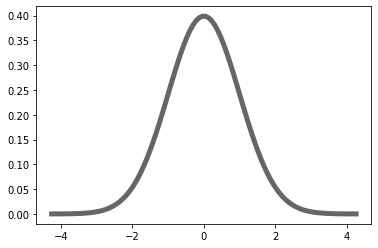

In [57]:
fig, ax = plt.subplots(1, 1)
x = np.linspace(stats.norm.ppf(0.00001),
                stats.norm.ppf(0.99999), 100)
ax.plot(x, stats.norm.pdf(x),
       'k-', lw=5, alpha=0.6, label='norm pdf')

Vamos utilizar para esse teste, o nível de significância $\alpha = 0.05$ padrão nos testes de hipóteses. A regra de rejeição é

* Se p-value > $\alpha = 0.05$, então não rejeita-se $H_0$
* Se p-value < $\alpha = 0.05$, então rejeita-se $H_0$

Agora vamos definir uma função que faça todos esses cálculos.

In [58]:
def variance_ratio(df):
    df['Variance Ratio (VR)'] = (df['Variance'] / (df['k'] * df['Variance'].iloc[0])) - 1
    df['Variance of VR'] = (2 * (df['k'] - 1)*(2 * df['k'] - 1))/(3 * df['k'] * n)
    df['Standard Deviation of VR'] = np.sqrt(df['Variance of VR'])
    df['Statistic'] = df['Variance Ratio (VR)']/df['Standard Deviation of VR']
    df['p-value'] = stats.norm.sf(abs(df['Statistic']))

In [59]:
variance_ratio(ibov_VR)
variance_ratio(ibov_real_VR)
variance_ratio(vale_VR)
variance_ratio(vale_real_VR)
variance_ratio(bbas_VR)
variance_ratio(bbas_real_VR)

Vamos dropar a primeira linha. Não há a necessidade de fazer o teste de hipótese entre a série diária com ela mesma.

In [60]:
ibov_VR = ibov_VR[1:]
ibov_real_VR = ibov_real_VR[1:]
vale_VR = vale_VR[1:]
vale_real_VR = vale_real_VR[1:]
bbas_VR = bbas_VR[1:]
bbas_real_VR = bbas_real_VR[1:]

Vamos criar mais uma função que atribui à série a rejeição ou não da hipótes nula

In [61]:
def null_hypothesis(df):
    for i in range(len(df)):
        df['Reject null hypothesis'] = df['Reject null hypothesis'].astype("string")
        if df['p-value'][i] > 0.05:
            df['Reject null hypothesis'][i] = 'Não'
        elif df['p-value'][i] < 0.05:
            df['Reject null hypothesis'][i] = 'Sim'
        else:
            pass   

In [62]:
null_hypothesis(ibov_VR)
null_hypothesis(ibov_real_VR)
null_hypothesis(vale_VR)
null_hypothesis(vale_real_VR)
null_hypothesis(bbas_VR)
null_hypothesis(bbas_real_VR)

In [63]:
ibov_VR

,Variance,k,Variance Ratio (VR),Variance of VR,Standard Deviation of VR,Statistic,p-value,Reject null hypothesis
IBOV_(t-5),0.001446,5.0,-0.084445,0.000855,0.029246,-2.887419,0.001942,Sim
IBOV_(t-22),0.006307,22.0,-0.092281,0.004876,0.069828,-1.321547,0.093160,Não
IBOV_(t-126),0.037482,126.0,-0.058117,0.029580,0.171990,-0.337909,0.367716,Não
IBOV_(t-252),0.087254,252.0,0.096287,0.059516,0.243959,0.394684,0.346538,Não
IBOV_(t-504),0.196771,504.0,0.236146,0.119387,0.345525,0.683443,0.247164,Não


In [64]:
ibov_real_VR

,Variance,k,Variance Ratio (VR),Variance of VR,Standard Deviation of VR,Statistic,p-value,Reject null hypothesis
IBOV_real_(t-5),0.001443,5.0,-0.086000,0.000855,0.029246,-2.940588,0.001638,Sim
IBOV_real_(t-22),0.006266,22.0,-0.098103,0.004876,0.069828,-1.404926,0.080022,Não
IBOV_real_(t-126),0.036205,126.0,-0.090061,0.029580,0.171990,-0.523644,0.300263,Não
IBOV_real_(t-252),0.079614,252.0,0.000468,0.059516,0.243959,0.001918,0.499235,Não
IBOV_real_(t-504),0.158829,504.0,-0.002045,0.119387,0.345525,-0.005917,0.497639,Não


In [65]:
vale_VR

,Variance,k,Variance Ratio (VR),Variance of VR,Standard Deviation of VR,Statistic,p-value,Reject null hypothesis
VALE3_(t-5),0.003218,5.0,-0.066257,0.000855,0.029246,-2.265532,0.011740,Sim
VALE3_(t-22),0.012969,22.0,-0.144628,0.004876,0.069828,-2.071210,0.019170,Sim
VALE3_(t-126),0.083288,126.0,-0.040857,0.029580,0.171990,-0.237558,0.406112,Não
VALE3_(t-252),0.230666,252.0,0.328176,0.059516,0.243959,1.345210,0.089279,Não
VALE3_(t-504),0.645674,504.0,0.858894,0.119387,0.345525,2.485769,0.006464,Sim


In [66]:
vale_real_VR

,Variance,k,Variance Ratio (VR),Variance of VR,Standard Deviation of VR,Statistic,p-value,Reject null hypothesis
VALE3_real_(t-5),0.003213,5.0,-0.067540,0.000855,0.029246,-2.309386,0.010461,Sim
VALE3_real_(t-22),0.012889,22.0,-0.149737,0.004876,0.069828,-2.144380,0.016001,Sim
VALE3_real_(t-126),0.079645,126.0,-0.082650,0.029580,0.171990,-0.480553,0.315417,Não
VALE3_real_(t-252),0.208820,252.0,0.202585,0.059516,0.243959,0.830407,0.203154,Não
VALE3_real_(t-504),0.515646,504.0,0.484793,0.119387,0.345525,1.403063,0.080299,Não


In [67]:
bbas_VR

,Variance,k,Variance Ratio (VR),Variance of VR,Standard Deviation of VR,Statistic,p-value,Reject null hypothesis
BBAS3_(t-5),0.003668,5.0,-0.046337,0.000855,0.029246,-1.584395,0.056552,Não
BBAS3_(t-22),0.015017,22.0,-0.112707,0.004876,0.069828,-1.614078,0.053255,Não
BBAS3_(t-126),0.083887,126.0,-0.134588,0.029580,0.171990,-0.782536,0.216950,Não
BBAS3_(t-252),0.169838,252.0,-0.123946,0.059516,0.243959,-0.508061,0.305705,Não
BBAS3_(t-504),0.433524,504.0,0.118097,0.119387,0.345525,0.341791,0.366254,Não


In [68]:
bbas_real_VR

,Variance,k,Variance Ratio (VR),Variance of VR,Standard Deviation of VR,Statistic,p-value,Reject null hypothesis
BBAS3_real_(t-5),0.003660,5.0,-0.048223,0.000855,0.029246,-1.648878,0.049586,Sim
BBAS3_real_(t-22),0.014881,22.0,-0.120498,0.004876,0.069828,-1.725642,0.042206,Sim
BBAS3_real_(t-126),0.080157,126.0,-0.172836,0.029580,0.171990,-1.004919,0.157468,Não
BBAS3_real_(t-252),0.151784,252.0,-0.216846,0.059516,0.243959,-0.888865,0.187038,Não
BBAS3_real_(t-504),0.333630,504.0,-0.139290,0.119387,0.345525,-0.403126,0.343428,Não


O teste de razão da variância de Lo and MacKinlay visa verificar como as séries de retornos diários de um ativo estão relacionadas com as a série de retornos de $k$-dias do mesmo ativo. Os resultados mostram quem conforme $k$ aumenta, as chances são maiores de não rejeitar $H_0$ de independência entre os dados.

Analisando mais minuciosamente, verifica-se que entre as séries do Ibovespa Nominal e Real, apenas a série de retornos semanais rejeita $H_0$ indicando dependência na estrutura dos retornos, enquanto que para os demais retornos $H_0$ não é rejeitada. Para as séries das ações preferenciais da Vale, o resultado encontrado é que há rejeição de $H_0$ para os retornos semanais e mensais para ambas séries nominais ou reais, enquanto para retornos semestrais e anuais, a hipótese nula não é rejeitada, também para ambas séries nominais e reais, por fim, para retornos de dois anos, a série nominal da Vale rejeita $H_0$, enquanto a série real não. Finalmente, a série retornos do Banco do Brasil em termoss nominais não rejeita $H_0$ para todos retornos, ao passo que em termos reais, a hipótese nula é rejeitada para os retornos semanais e mensais e não rejeitada para retornos semestrais, anuais e de dois anos.